# **SCNN Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# File path for the uploaded dataset
zip_file_path = '/content/drive/MyDrive/dl data2/archive (7).zip'
extracted_folder_path = '/content/drive/MyDrive/dl data2/extracted'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Listing the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
extracted_files


['driver_161_90frame', 'driver_161_90frame_labels']

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import cv2

processing and analyzing numerical data particularly where coordinates are involved.

In [ ]:
def remove_newlines(fname):
    data=[]
    coordinates =[]
    flist = open(fname).readlines()
    for s in flist:
        data.extend([d for d in s.rstrip('\n').split(" ")  if d!=''])

    data = np.array(data).astype(np.float32)

    for idx in range(0,len(data),2):
        coordinates.append(data[idx:idx+2])
    if(len(data)==0):
        return None , None  , 0 , 0

    else:

        mean_val = np.mean(data)
        std_val = np.std(data)
        return coordinates , data , mean_val  , std_val

The function reads the file, removes newline characters, and splits the data into individual elements. It then converts these elements into floating-point numbers and groups them into coordinate pairs. If the file is empty, the function returns None for the coordinates and data, and zeros for the mean and standard deviation. Otherwise, it calculates and returns the mean and standard deviation of the data along with the list of coordinates and the raw data array.

Extracting The dataset

In [ ]:
from os import walk

img_files = []
label_data=[]
mean_array=[]
std_array = []
coordinate_list=[]
for dirpath, dirnames, filenames in walk("/content/drive/MyDrive/dl data2/extracted/driver_161_90frame"):
    for files in filenames :
        if(files.split(".")[-1]=="jpg"):
            txt_file = os.path.join(dirpath , files.split(".")[0]+str(".lines.txt") )
            coordinates , data , mean_val , std_val  = remove_newlines(txt_file)
            if(data is not None):
                img_files.append(os.path.join(dirpath,files))
                label_data.append( data )
                mean_array.append(mean_val)
                std_array.append(std_val)
                coordinate_list.append(coordinates)


In [ ]:
import os
results=[]
with open("/content/train_gt.txt") as f:
    for line in f :
        line = line.strip()
        data = line.split(" ")
        set1 = data[0].split(os.path.sep)[1:]
        if(set1[0] == "driver_161_90frame"):
            results.append(data)

Here we are filtering and storing information from train_gt.txt for frames that belong specifically to the data set folder. This filtered data in results  includes the paths to these specific frames and their corresponding label images, along with some additional numerical values.







Now we'll processes a list of image and label paths with additional numerical data and create a structured dataset with full paths and lane existence information for each image.







In [ ]:
import cv2
data_set=[]
for data in results :
    exist=[int(x) for x in data[2:]]
    img_sep = data[0].split(os.path.sep)
    label_sep = data[1].split(os.path.sep)
    label_path = os.path.join("/content/drive/MyDrive/dl data2/extracted/driver_161_90frame_labels" , label_sep[-2], label_sep[-1])
    img_path= os.path.join("/content/drive/MyDrive/dl data2/extracted", img_sep[1] , img_sep[2] , img_sep[3])
    dict_culane={
        "img_path":img_path ,
        "label_path":label_path ,
        "exist":exist
    }
    data_set.append(dict_culane)

# **Image normalization, resize, train test split **

In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import numpy as np
class CreateDataSet(Dataset):
    def __init__(self,data_set , seed):
        self.data_set = data_set
        self.seed = torch.manual_seed(seed)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((288,800)) ,
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225] )
        ])
        self.transform_label = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((288,800)) ,
        ])
        self.transform_exist = transforms.Compose([
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.data_set)

    def __getitem__(self,index):
        data_item = self.data_set[index]
        #read the image data
        img = cv2.imread(data_item["img_path"])
        img_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        img_rgb = self.transform(img_rgb)
        #read the label image
        label = cv2.imread(data_item["label_path"])[:,:,0]
        label = np.array(self.transform_label(label))
        if(len(data_item["exist"]) ==4 and label is not None):
            exists = np.array(data_item["exist"])

        else:
            exists = None
        exists = torch.from_numpy(exists)
        sample = {
            "data":img_rgb ,
            "target":label ,
            "exist":exists
        }

        return sample

In [ ]:
train_data = CreateDataSet(data_set , 0)

size_train = len(train_data)
idx_list = list(range(size_train))
np.random.seed(0)
np.random.shuffle(idx_list)
train_val_split = 0.2
split_index = int(size_train * train_val_split)

train_idx = idx_list[split_index :]
val_idx = idx_list[:split_index]

train_sampler = SubsetRandomSampler(train_idx)
validate_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_data ,sampler=train_sampler , batch_size=16 )
valid_loader = DataLoader(train_data , sampler=validate_sampler , batch_size=16)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# **Defining the model**

In [ ]:
class SCNN(nn.Module):
    def __init__(self , input_size , massage_kernel = 9 , pretrained=True):
        super(SCNN , self).__init__()
        self.pretrained = pretrained
        self.net_init(input_size , massage_kernel)
        self.scale_background = 0.4
        self.scale_seg = 1.0
        self.scale_exist = 0.1

        self.ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([self.scale_background, 1, 1, 1, 1]))
        self.bce_loss = nn.BCELoss()

    def net_init(self,input_size , ms_ks):
        input_w , input_h = input_size
        self.fc_input_size = 5 * int(input_w/16) * int(input_h/16)
        self.backbone = models.vgg16_bn(pretrained=self.pretrained).features

        #replace the standard convs with dilated convs
        for i in [34 , 37 , 40]:
            conv = self.backbone._modules[str(i)]
            dilated_conv = nn.Conv2d(conv.in_channels , conv.out_channels  , conv.kernel_size ,
                                    stride=conv.stride , padding = tuple(p*2 for p in conv.padding) ,
                                    dilation=2 , bias = (conv.bias is not None))
            dilated_conv.load_state_dict(conv.state_dict())
            self.backbone._modules[str(i)] = dilated_conv
        self.backbone._modules.pop('33')
        self.backbone._modules.pop('43')

        #scnn unit
        self.layer1 = nn.Sequential(
            nn.Conv2d(512 , 1024 ,3 ,  padding=4 , dilation=4 , bias=False) ,
            nn.BatchNorm2d(1024) ,
            nn.ReLU() ,
            nn.Conv2d(1024 , 128 , 1 , bias=False),
            nn.ReLU()
        )

        # add message passing
        self.message_passing = nn.ModuleList()
        self.message_passing.add_module("up_down" , nn.Conv2d( 128 , 128 , (1 , ms_ks) , padding=(0,ms_ks//2) , bias=False     ))
        self.message_passing.add_module("down_up" , nn.Conv2d(128,128,(1,ms_ks) , padding=(0,ms_ks//2) , bias=False))
        self.message_passing.add_module('left_right',nn.Conv2d(128,128,(ms_ks , 1) , padding=(ms_ks//2 , 0) , bias=False))
        self.message_passing.add_module("right_left" , nn.Conv2d(128,128,(ms_ks , 1) , padding=(ms_ks//2 , 0) , bias=False))

        self.layer2 = nn.Sequential(
            nn.Dropout2d(0.1) ,
            nn.Conv2d(128,5,1)
        )
        self.layer3 = nn.Sequential(
            nn.Softmax(dim=1) ,
            #dimension reducion by 2
            nn.AvgPool2d(2,2) ,
        )

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size , 128) ,
            nn.ReLU(),
            nn.Linear(128,4),
            nn.Sigmoid()
        )

    def message_passing_forward(self , x):
        Vertical=[True , True , False , False ]
        Reverse = [False , True , False , True]
        for ms_conv  , v , r in zip(self.message_passing , Vertical , Reverse):
            x = self.message_passing_once(x  , ms_conv , v , r)
        return x

    def message_passing_once(self,x  , ms_conv , vertical=True , reverse=True):
        nB , C , H , W = x.shape
        if vertical :
            slices =[  x[: , : , i : (i+1) , : ] for i in range(H)  ]
            dim=2
        else :
            slices = [ x[: , : , : , i: (i+1)] for i in range(W) ]
            dim=3
        if reverse :
            slices = slices[::-1]

        #then each slice convole with the conv layer and add to the previous layer
        out = [ slices[0]]
        for i in range(1, len(slices)):
            out.append(slices[i]+F.relu(ms_conv(out[i-1])))

        if reverse :
            out = out[::-1]
        #concatenate the tensors with the dimension
        return torch.cat(out , dim=dim)

    def forward(self,img , seg_img=None , exist_gt=None):
        #inference thorught the vgg16 backbone net
        x = self.backbone(img)
        x = self.layer1(x)
        x = self.message_passing_forward(x)
        x = self.layer2(x)

        #then to obtain the original image size need to upsample by 8
        seg_pred = F.interpolate(x  , scale_factor=8 , mode='bilinear' , align_corners=True)
        x = self.layer3(x)
        x = x.view(-1  , self.fc_input_size)
        exist_pred = self.fc(x)

        if seg_img is not None and exist_gt is not None:
            loss_seg = self.ce_loss(seg_pred , seg_img.long().squeeze(1))
            loss_exist = self.bce_loss(exist_pred.float() , exist_gt.float())
            #nned to pay more attention on the segmanetation loss and weight should be high
            loss = loss_seg * self.scale_seg + loss_exist * self.scale_exist

        else:
            loss_seg = torch.tensor(0,dtype=img.dtype , device=img.device)
            loss_exist = torch.tensor(0,dtype=img.dtype , device=img.device)
            loss = torch.tensor(0,dtype=img.dtype , device=img.device)

        return seg_pred , exist_pred , loss_seg , loss_exist , loss


SCNN stands for  spatial convolutional neural network. It specialized in lane detection in images. It customizes a VGG16 backbone with dilated convolutions for better feature extraction, and employs message passing techniques for capturing spatial dependencies. The network outputs both lane segment predictions and lane existence probabilities. The loss function is a combination of cross-entropy for segmentation and binary cross-entropy for existence prediction, with different scaling factors to balance their importance.

The SCNN is suitable for lane detection due to its ability to effectively capture both local features (through the VGG16 backbone) and spatial relationships (through message passing), crucial for accurately identifying lane boundaries and their patterns. The use of dilated convolutions allows the network to have a larger receptive field, enhancing its ability to detect lanes over a wider area of the input image.

Interpreting the results, the network would provide both the segmented lane markings and the probability of existence for each lane. The accuracy of these predictions and the overall loss value (combining segmentation and existence accuracy) would indicate the network's effectiveness in identifying and classifying lane markings in various driving scenarios.

In [ ]:
#define the model
scnn_net = SCNN((800,288) , pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 88.6MB/s]


Defineing the optimizer and lr optimizers

In [ ]:

import torch.optim as optim
init_lr =  0.0001
max_lr = 0.01
optimizer = optim.SGD(scnn_net.parameters() , lr=init_lr)
#set the learining rate schedulers  scheduler need to be call for every batch operation
scheduler = optim.lr_scheduler.CyclicLR(optimizer , base_lr=init_lr , max_lr=max_lr)
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
scnn_net.to(device)

SCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

**Backbone**: A modified VGG16 network, with some layers replaced by dilated convolutions to increase the receptive field without losing resolution.

**Layer 1**: A sequence of convolutional, batch normalization, and ReLU layers, followed by a reduction in the number of channels.

**Message Passing**: Four convolutional layers for message passing in different directions (up-down, down-up, left-right, right-left). This is crucial for capturing spatial relationships in the image, particularly for continuous lane lines.

**Layer 2**: Consists of a dropout layer for regularization and a convolutional layer to output five channels, corresponding to different lane line types or background.

**Layer 3**: Applies softmax for classification and average pooling to reduce dimensions.

**Fully Connected (FC) Layer**: Processes the feature map into a final output, predicting the existence of lanes.

**Loss Functions**: Cross-entropy loss for lane line segmentation and binary cross-entropy loss for lane existence prediction.



In [ ]:
from collections import namedtuple
Label = namedtuple( 'Label' , [

        'name' ,

        'id' ,

        'color' ,
        ] )

In [ ]:
labels = [
    #        lane mark             index       lane colour
    Label(  'background'            ,  0 ,     (0, 0,0)        ),
    Label(  'lane1'                 ,  1 ,     (255, 0,0)        ),
    Label(  'lane2'                 ,  2 ,     (150, 35,232)     ),
    Label(  'lane3'                 ,  3 ,     ( 0, 70, 70)      ),
    Label(  'lane4'                 ,  4 ,     (102,102,255)     )
]

This is done for semantic segmentation, where each pixel of an image is classified into one of these categories. The color coding can be used to visually differentiate the lanes in output images, making it easier to interpret the results of the lane detection model.







In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn.functional as F

# PyTroch version

SMOOTH = 1e-6
fig = plt.figure(figsize=(10,10))
def plot_results(ori_image , result_img , result_exist , label):
    print("Lane Line existing Probability : ",result_exist)
    plot_img(ori_image)
    plot_label(label)
    class_image = iou_result(result_img)
    convert(class_image)
    return class_image



<Figure size 1000x1000 with 0 Axes>

here we takes the original image, the result image (segmentation mask), the probability of lane existence, and the label. Then we prints the probability of lane line existence, plots the original image, the original label, and then processes the result image to create a class image (segmentation mask with color coding). It finally converts and plots this class image for visualization.



In [ ]:
def iou_result(outputs):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(0)
    outputs = outputs.reshape(5 ,288,800)
    outputs = torch.tensor(outputs , dtype=torch.float , device='cpu').unsqueeze(0)
    output_prob = F.log_softmax(outputs , dim=1)
    #take the argmax value in the dim 1
    output_class = torch.argmax(output_prob , dim=1)
    output_class = output_class.squeeze(0)
    return output_class # Or thresholded.mean() if you are interested in average across the batch


Here we process the output of a model to get a class image. This function reshapes the output to the desired dimensions, applies a softmax function to get probabilities, and then uses torch.argmax to get the most likely class for each pixel. The result is a 2D tensor representing the segmentation mask.



In [ ]:
def convert(mask):
    mask = mask.numpy()
    height , width = mask.shape
    copy_img = np.zeros((height , width , 3) , dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            idx = mask[i][j]
            label = labels[idx]
            color = label.color
            copy_img[i][j]=color
    plt.title("Segment Mask")
    plt.imshow(copy_img)
    plt.show()

This function takes a mask (segmentation mask) and converts it into a color-coded image for visualization. It iterates through each pixel of the mask, looks up the corresponding color in the labels list defined earlier, and creates a color image.



In [ ]:
def plot_img(image):
    #unnormallize the image
    image = image.reshape(3, 288,800)
    image = np.transpose(image , (1,2,0))
    plt.title("Original Image")
    plt.imshow(image)
    plt.show()

This function plots the original image. It reshapes and transposes the image to get it in the right format

In [ ]:
def plot_label(image):
    #unnormallize the image
    image = image.reshape(288,800)
    plt.title("Original Image")
    plt.imshow(image)
    plt.show()

this function is used for plotting the label (ground truth segmentation mask) of the original image.



# **Training the Model**

Epoch : 0 Mean Seg Loss : 0.48347 Mean Exist Loss : 0.683610 Mean Total Loss : 0.551827 


Lane Line existing Probability :  [[0.52508336 0.5652325  0.55730104 0.48385406]]


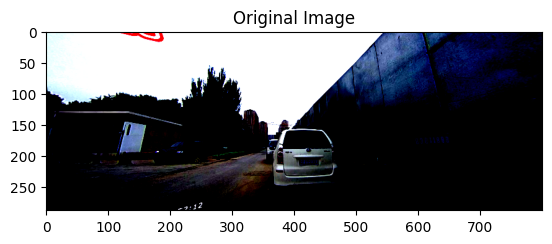

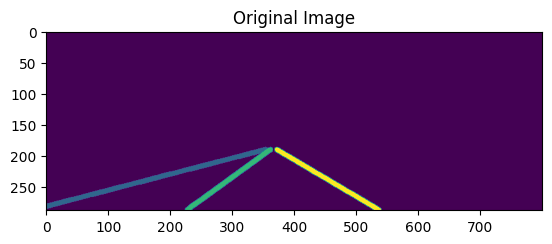

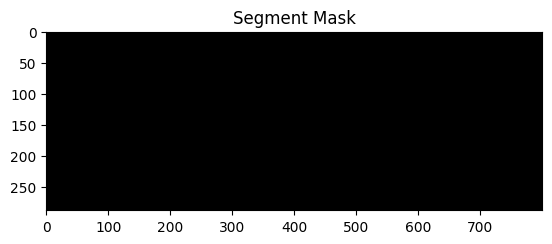

Epoch : 0 Mean Seg Loss : 0.37536 Mean Exist Loss : 0.647907 Mean Total Loss : 0.440153 


Lane Line existing Probability :  [[0.55048794 0.69762343 0.6681031  0.5030137 ]]


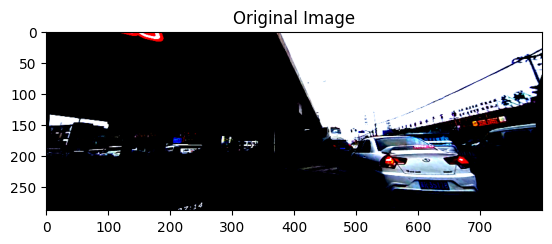

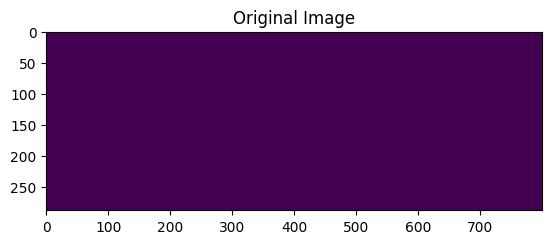

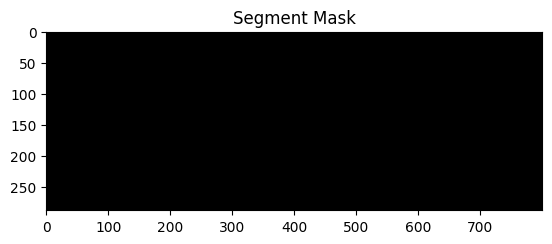

Epoch : 0 Mean Seg Loss : 0.33227 Mean Exist Loss : 0.616697 Mean Total Loss : 0.393941 


Lane Line existing Probability :  [[0.5712089 0.793859  0.7678117 0.5396396]]


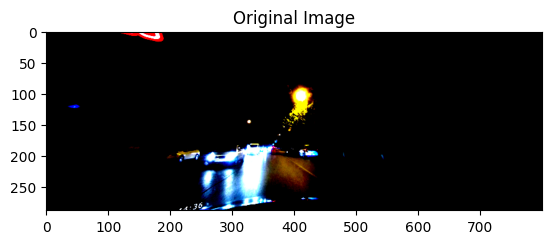

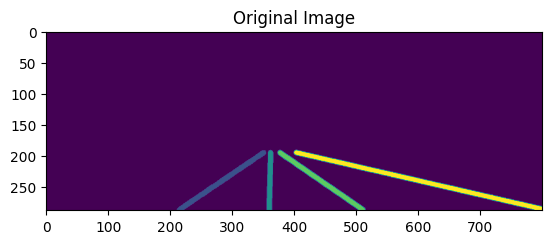

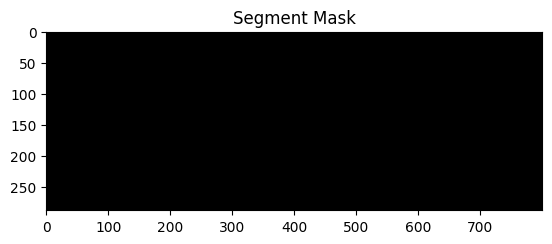

Epoch : 0 Mean Seg Loss : 0.30704 Mean Exist Loss : 0.593934 Mean Total Loss : 0.366434 


Lane Line existing Probability :  [[0.5606763  0.84542435 0.8350343  0.593457  ]]


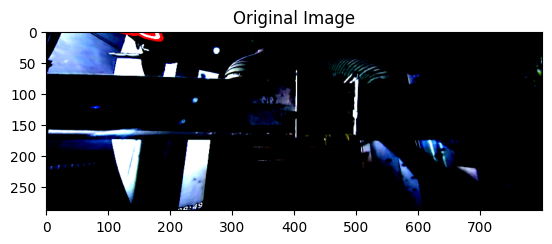

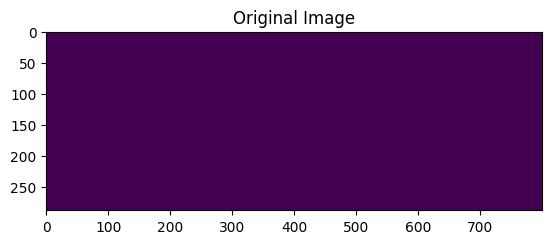

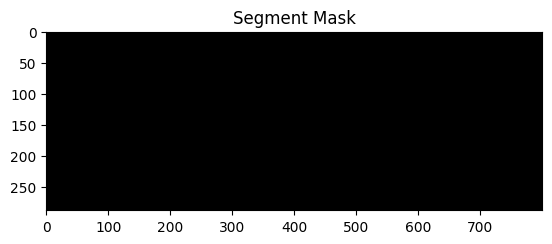

Epoch : 0 Mean Seg Loss : 0.28749 Mean Exist Loss : 0.582574 Mean Total Loss : 0.345752 


Lane Line existing Probability :  [[0.5310659  0.8572061  0.8513948  0.60579777]]


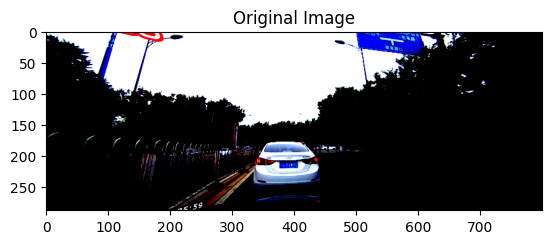

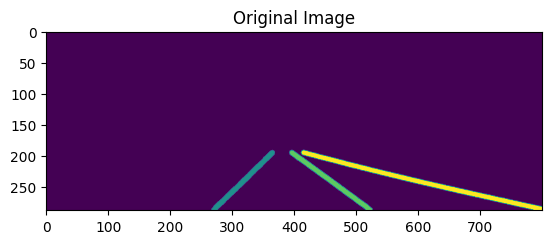

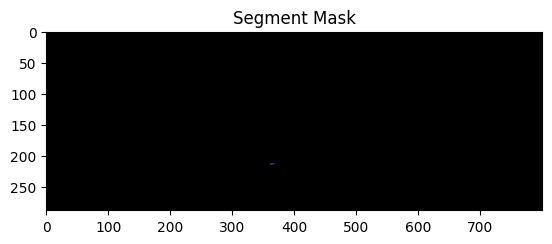

Epoch : 0 Mean Seg Loss : 0.27163 Mean Exist Loss : 0.571420 Mean Total Loss : 0.328770 


Lane Line existing Probability :  [[0.5474464  0.8837638  0.87841773 0.64146024]]


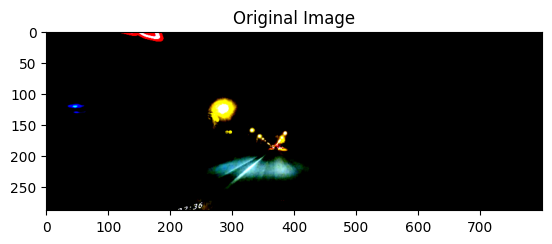

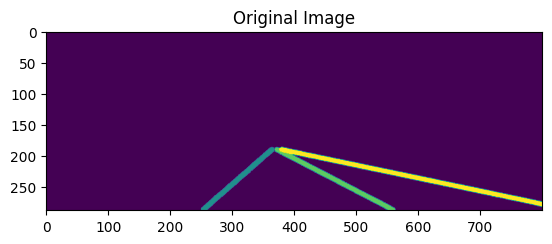

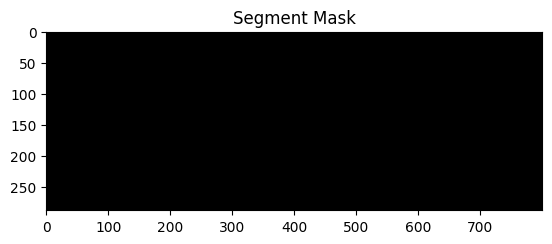

Epoch : 0 Mean Seg Loss : 0.25820 Mean Exist Loss : 0.563038 Mean Total Loss : 0.314506 


Lane Line existing Probability :  [[0.5675955  0.8925543  0.8872982  0.61962974]]


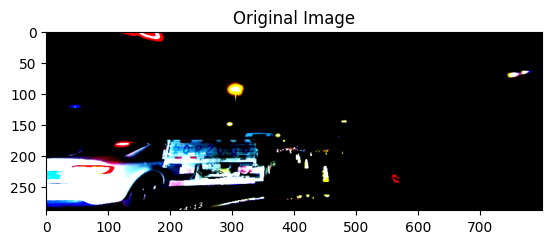

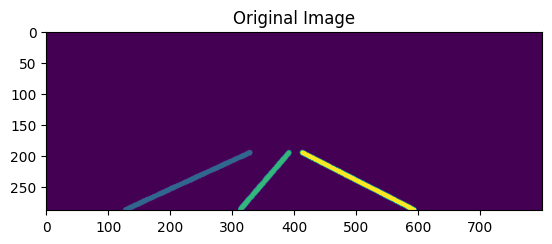

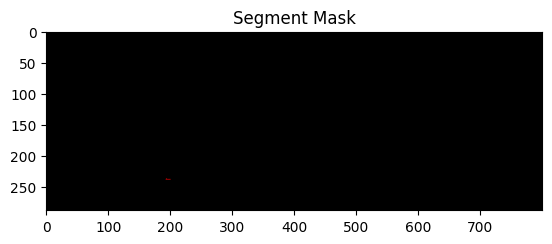

Epoch : 0 Mean Seg Loss : 0.24728 Mean Exist Loss : 0.556943 Mean Total Loss : 0.302975 


Lane Line existing Probability :  [[0.55580944 0.8887644  0.8816548  0.6292127 ]]


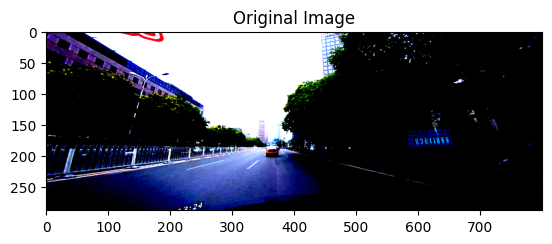

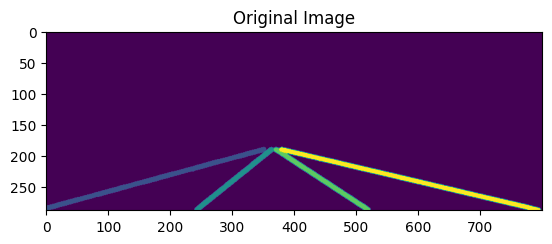

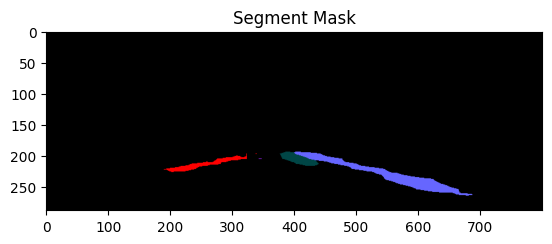

Epoch : 0 Mean Seg Loss : 0.23832 Mean Exist Loss : 0.551048 Mean Total Loss : 0.293423 


Lane Line existing Probability :  [[0.5734962  0.89724386 0.8893174  0.64034945]]


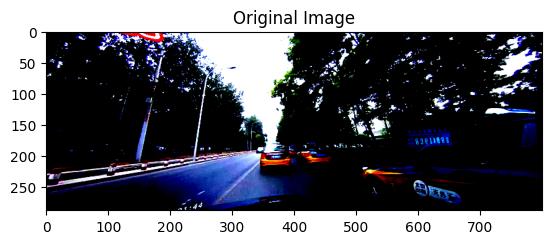

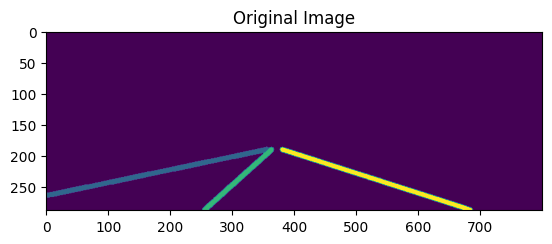

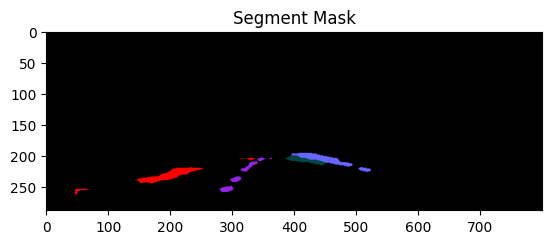

Epoch : 0 Mean Seg Loss : 0.23726 Mean Exist Loss : 0.550039 Mean Total Loss : 0.292261 
Epoch : 1 Mean Seg Loss : 0.16105 Mean Exist Loss : 0.508115 Mean Total Loss : 0.211858 


Lane Line existing Probability :  [[0.5503699  0.88835955 0.88778794 0.6261066 ]]


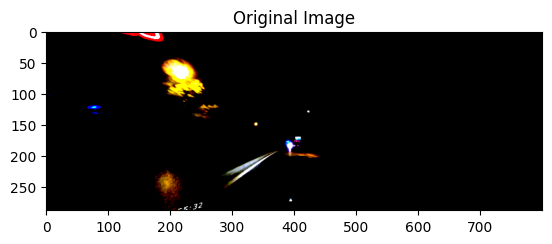

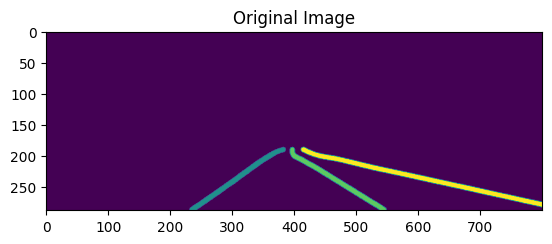

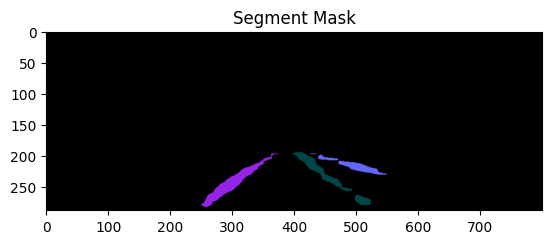

Epoch : 1 Mean Seg Loss : 0.15794 Mean Exist Loss : 0.512586 Mean Total Loss : 0.209200 


Lane Line existing Probability :  [[0.544583   0.8783468  0.87913334 0.59830046]]


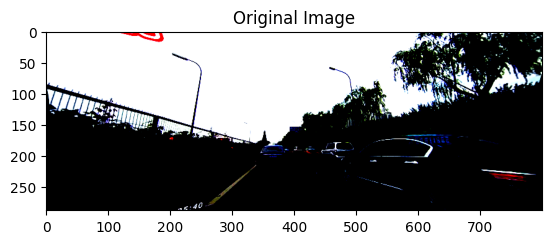

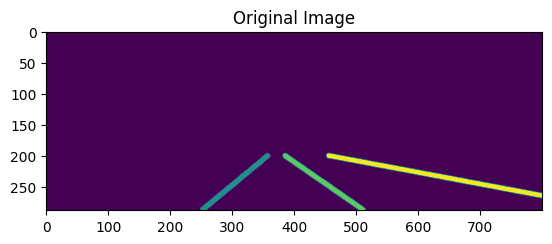

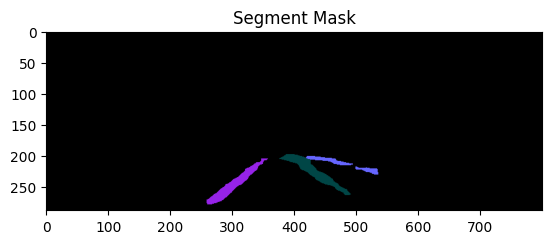

Epoch : 1 Mean Seg Loss : 0.15656 Mean Exist Loss : 0.512604 Mean Total Loss : 0.207825 


Lane Line existing Probability :  [[0.56242234 0.88472986 0.88032776 0.6199089 ]]


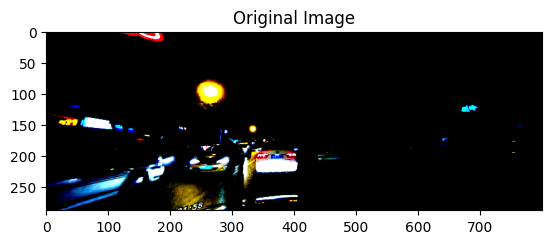

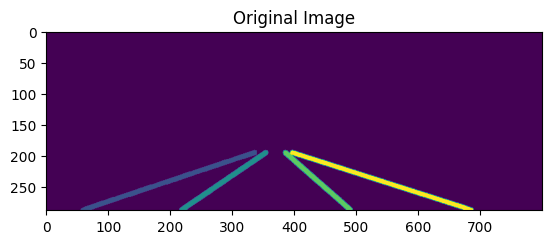

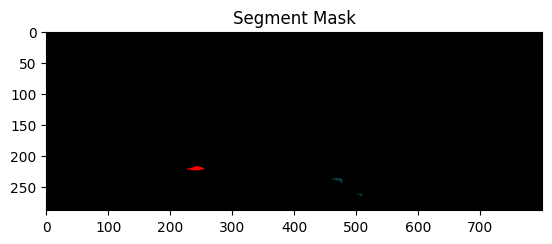

Epoch : 1 Mean Seg Loss : 0.15459 Mean Exist Loss : 0.512830 Mean Total Loss : 0.205877 


Lane Line existing Probability :  [[0.5423418  0.88005704 0.8773429  0.61825114]]


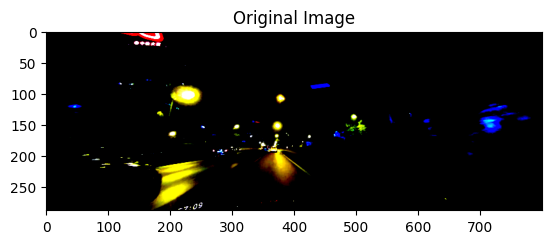

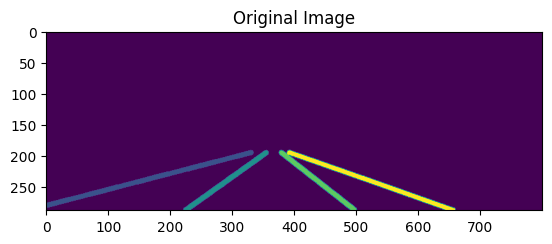

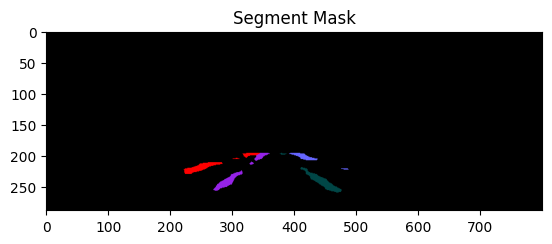

Epoch : 1 Mean Seg Loss : 0.15294 Mean Exist Loss : 0.512880 Mean Total Loss : 0.204232 


Lane Line existing Probability :  [[0.5807816  0.89012885 0.88215667 0.6157605 ]]


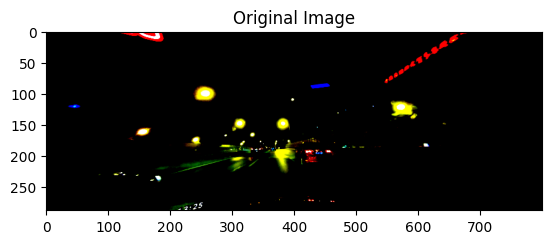

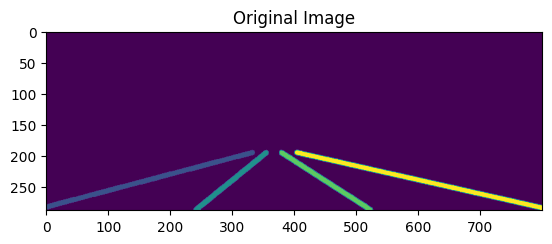

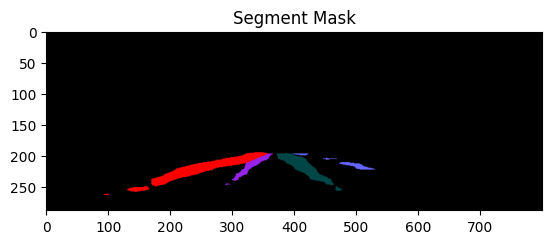

Epoch : 1 Mean Seg Loss : 0.15171 Mean Exist Loss : 0.511509 Mean Total Loss : 0.202859 


Lane Line existing Probability :  [[0.56072134 0.8798711  0.8736667  0.6053114 ]]


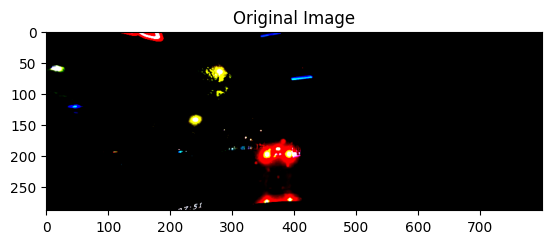

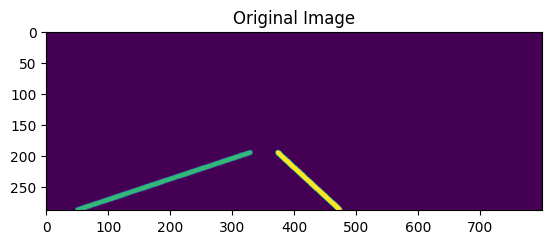

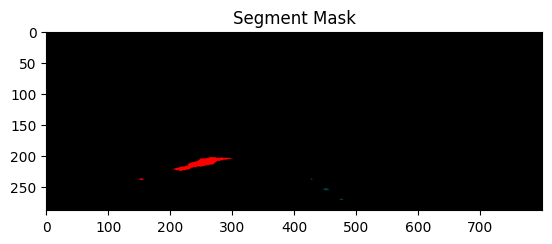

Epoch : 1 Mean Seg Loss : 0.15033 Mean Exist Loss : 0.508165 Mean Total Loss : 0.201149 


Lane Line existing Probability :  [[0.60165024 0.9029298  0.88618374 0.6093728 ]]


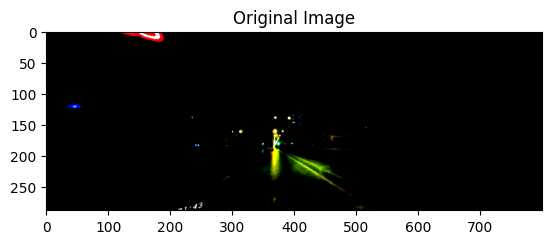

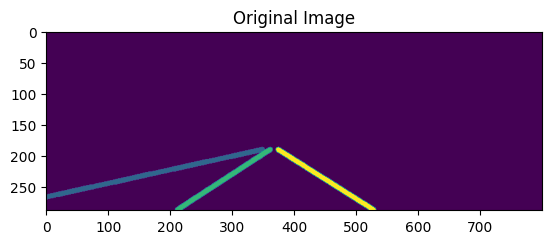

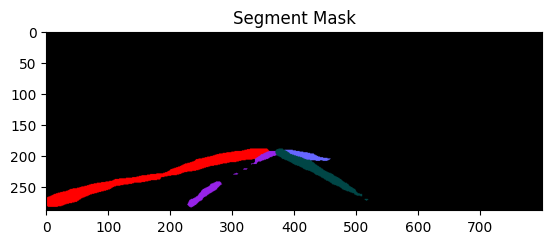

Epoch : 1 Mean Seg Loss : 0.14938 Mean Exist Loss : 0.504692 Mean Total Loss : 0.199852 


Lane Line existing Probability :  [[0.53222156 0.879148   0.88257796 0.6255156 ]]


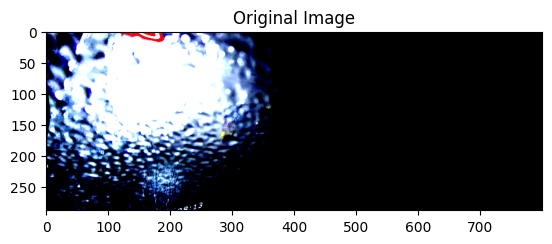

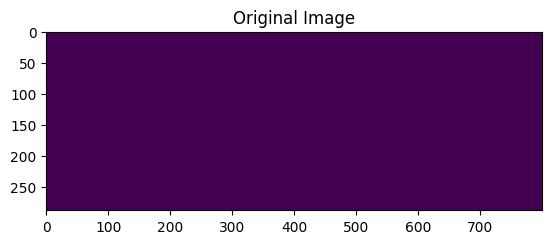

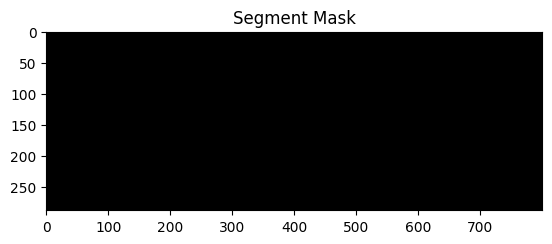

Epoch : 1 Mean Seg Loss : 0.14842 Mean Exist Loss : 0.499331 Mean Total Loss : 0.198355 


Lane Line existing Probability :  [[0.52975243 0.8928276  0.8978823  0.6533574 ]]


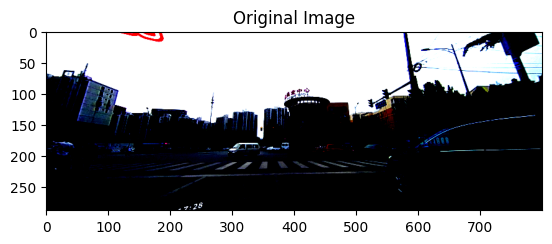

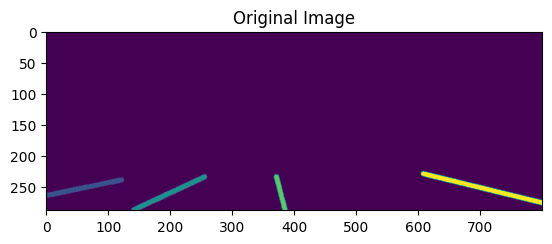

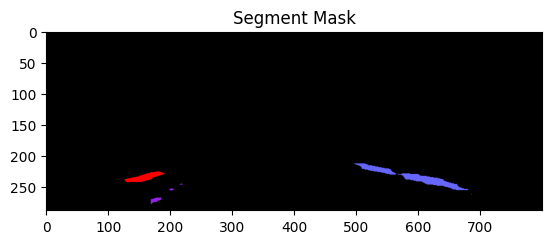

Epoch : 1 Mean Seg Loss : 0.19277 Mean Exist Loss : 0.524477 Mean Total Loss : 0.245219 
Epoch : 2 Mean Seg Loss : 0.13283 Mean Exist Loss : 0.478106 Mean Total Loss : 0.180638 


Lane Line existing Probability :  [[0.5436384 0.8908879 0.893277  0.6440526]]


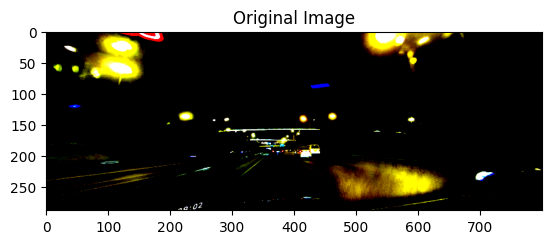

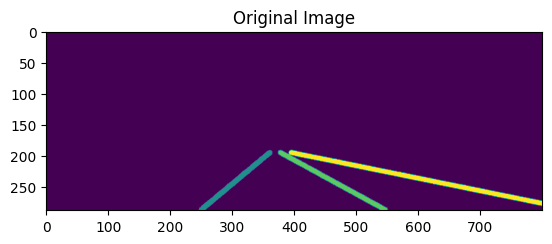

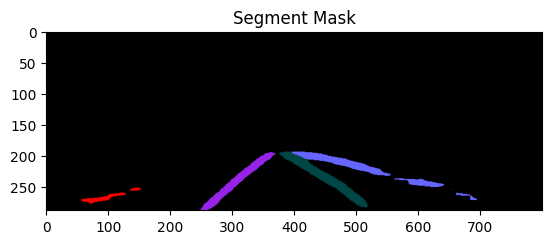

Epoch : 2 Mean Seg Loss : 0.13368 Mean Exist Loss : 0.467916 Mean Total Loss : 0.180471 


Lane Line existing Probability :  [[0.59806347 0.9058289  0.8957655  0.6393071 ]]


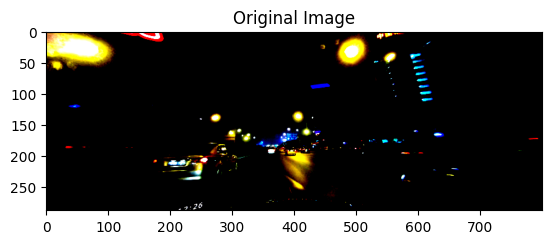

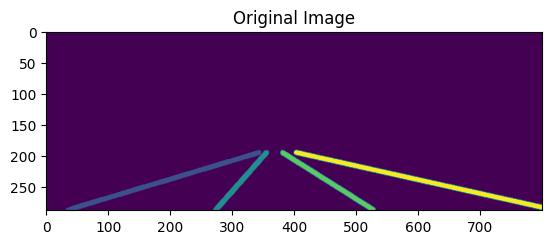

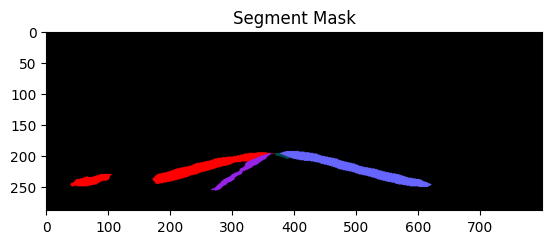

Epoch : 2 Mean Seg Loss : 0.13222 Mean Exist Loss : 0.466747 Mean Total Loss : 0.178891 


Lane Line existing Probability :  [[0.47649008 0.8780536  0.88312787 0.6731229 ]]


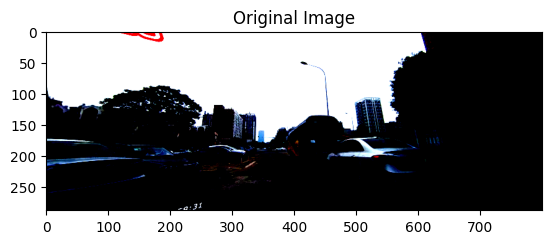

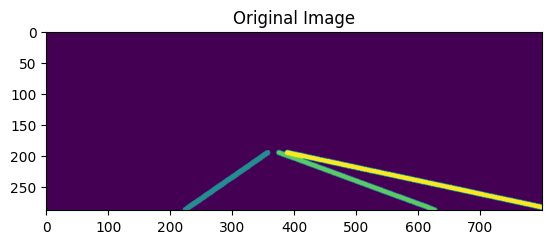

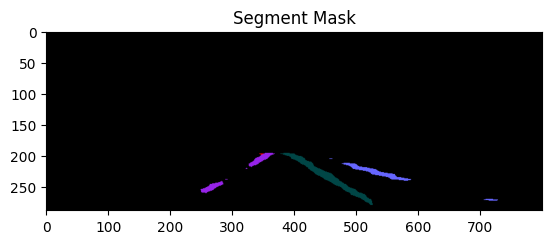

Epoch : 2 Mean Seg Loss : 0.13159 Mean Exist Loss : 0.464713 Mean Total Loss : 0.178065 


Lane Line existing Probability :  [[0.5959471  0.9027042  0.8920198  0.64355856]]


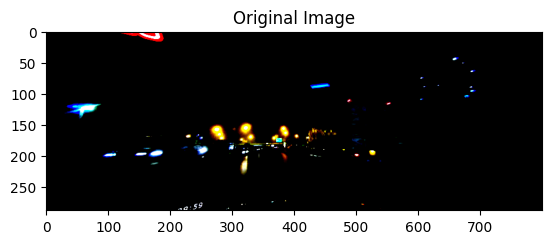

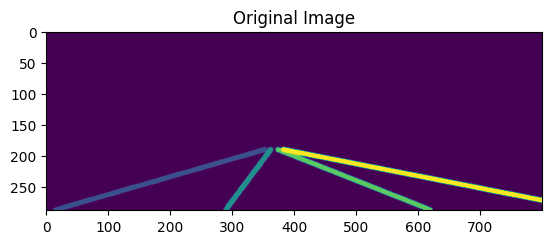

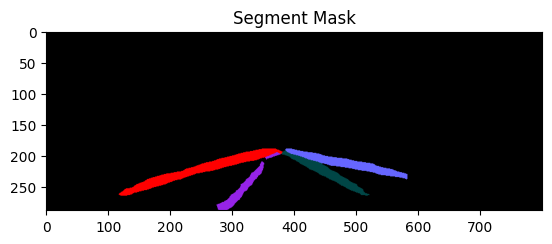

Epoch : 2 Mean Seg Loss : 0.13116 Mean Exist Loss : 0.461135 Mean Total Loss : 0.177272 


Lane Line existing Probability :  [[0.6838797  0.8865991  0.87572277 0.5207151 ]]


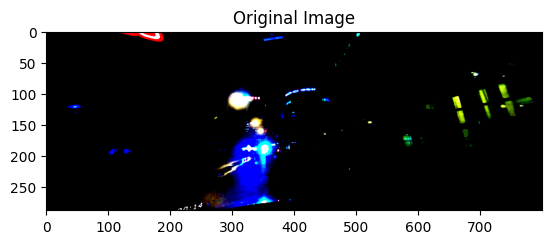

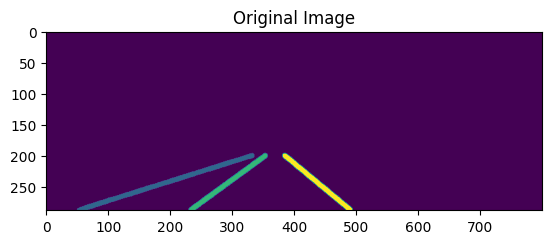

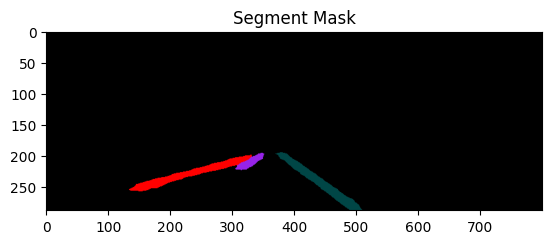

Epoch : 2 Mean Seg Loss : 0.13040 Mean Exist Loss : 0.455994 Mean Total Loss : 0.176002 


Lane Line existing Probability :  [[0.63678336 0.91845936 0.91208863 0.6859938 ]]


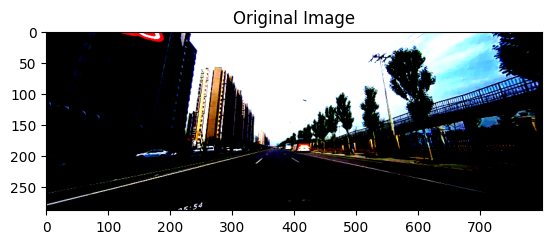

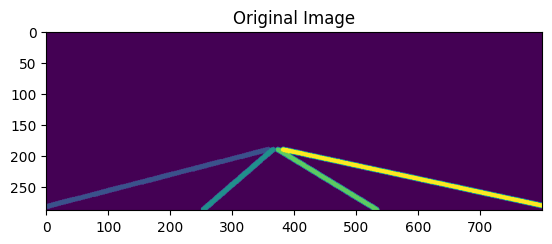

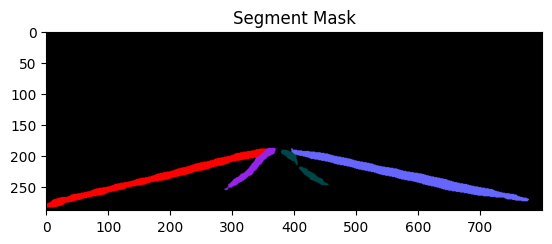

Epoch : 2 Mean Seg Loss : 0.12968 Mean Exist Loss : 0.452609 Mean Total Loss : 0.174940 


Lane Line existing Probability :  [[0.5491036 0.8409475 0.8404233 0.5320409]]


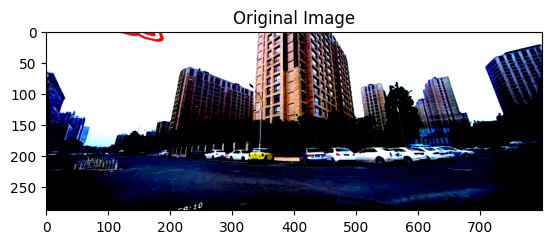

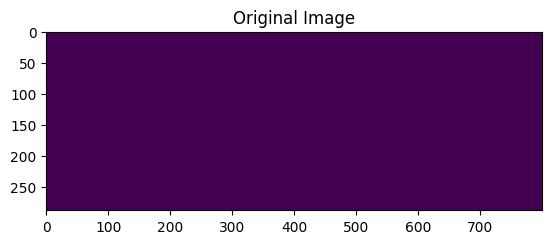

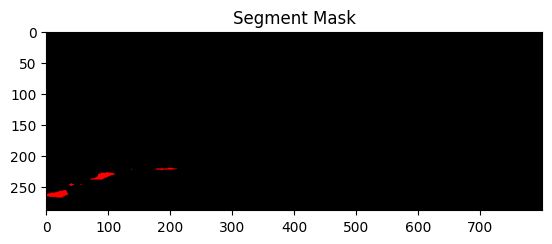

Epoch : 2 Mean Seg Loss : 0.12875 Mean Exist Loss : 0.447680 Mean Total Loss : 0.173517 


Lane Line existing Probability :  [[0.71239233 0.9075399  0.8884132  0.55467457]]


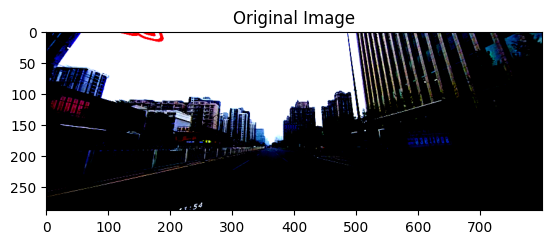

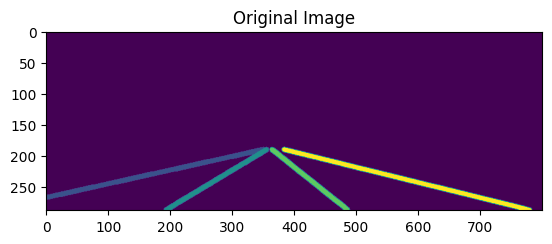

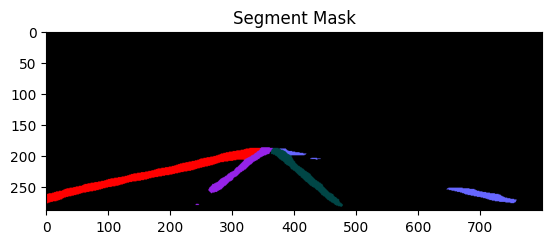

Epoch : 2 Mean Seg Loss : 0.12816 Mean Exist Loss : 0.441763 Mean Total Loss : 0.172339 


Lane Line existing Probability :  [[0.55518717 0.9041879  0.9047747  0.6977415 ]]


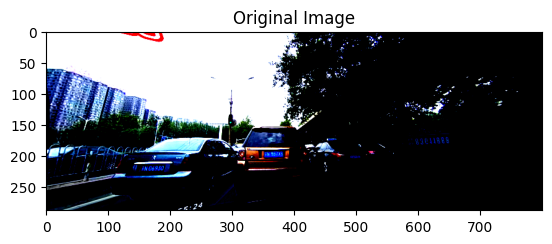

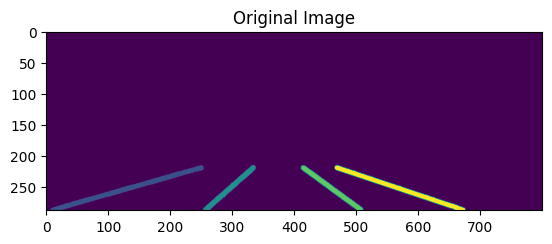

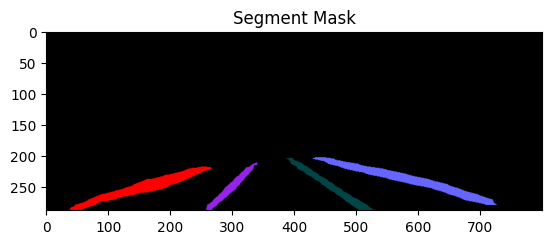

Epoch : 2 Mean Seg Loss : 0.17120 Mean Exist Loss : 0.496780 Mean Total Loss : 0.220883 


In [ ]:
from collections import deque
#define the train method
EPOCHS = 3
mean_loss        = deque(maxlen=100)
mean_seg_loss    = deque(maxlen=100)
mean_exist_loss  = deque(maxlen=100)
mean_vtotal_loss = deque(maxlen=100)
mean_vseg_loss   = deque(maxlen=100)
mean_vexist_loss = deque(maxlen=100)
for epoch in range(EPOCHS):
    e_loss_seg = 0
    e_loss_exist = 0
    e_loss_total =0
    ev_loss_seg =0
    ev_loss_exist =0
    ev_loss_total=0
    epoch_counter = 0
    for sample in train_loader :
        img_data = sample['data'].to(device)
        label_data = sample['target'].to(device)
        exist = sample['exist'].to(device)
        epoch_counter += 1
        seg_pred , exist_pred  , loss_seg , loss_exist , total_loss = scnn_net.forward(img_data , label_data , exist)
        #cumulate the losses
        e_loss_seg += loss_seg.to('cpu').detach().item()
        e_loss_exist  += loss_exist.to('cpu').detach().item()
        e_loss_total += total_loss.to('cpu').detach().item()
        #optimize the model
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        if((epoch_counter+1)%100==0):
            print("Epoch : {} Mean Seg Loss : {:.5f} Mean Exist Loss : {:.6f} Mean Total Loss : {:.6f} ".format(epoch ,
                                                                                                        e_loss_seg/epoch_counter ,
                                                                                                       e_loss_exist/epoch_counter,
                                                                                                       e_loss_total/epoch_counter))
            rand_int = np.random.choice(np.arange(len(img_data)))
            rand_img = img_data[rand_int].unsqueeze(0)
            label = label_data[rand_int].squeeze(0)
            seg_pred , exist_pred , _ , _ , _ = scnn_net.forward(rand_img)
            ori_img = rand_img.to('cpu').detach().numpy()
            seg_pred = seg_pred.to('cpu').detach().numpy()
            exist_pred = exist_pred.to('cpu').detach().numpy()
            label = label.to('cpu').detach().numpy()
            plot_results(ori_img , seg_pred , exist_pred , label)



    mean_seg_loss.append(e_loss_seg/len(train_loader))
    mean_exist_loss.append(e_loss_exist/len(train_loader))
    mean_loss.append(e_loss_total/len(train_loader))

    #validation data evaluation
    if((epoch+1)%5==0):
        scnn_net.eval()
        with torch.no_grad():
            for sample in valid_loader :
                img_data = sample['data'].to(device)
                label_data = sample['target'].to(device)
                exist = sample['exist'].to(device)

                seg_pred , exist_pred , loss_seg , loss_exist , loss_total = scnn_net.forward(img_data , label_data , exist)

                ev_loss_seg += loss_seg.to('cpu').detach().item()
                ev_loss_exist += loss_exist.to('cpu').detach().item()
                ev_loss_total += loss_total.to('cpu').detach().item()

            mean_vseg_loss.append(ev_loss_seg/len(valid_loader))
            mean_vexist_loss.append(ev_loss_exist/len(valid_loader))
            mean_vtotal_loss.append(ev_loss_total/len(valid_loader))

            #take a random sample from image
            rand_int = np.random.choice(np.arange(len(img_data)))
            rand_img = img_data[rand_int].unsqueeze(0)
            seg_pred , exist_pred , _ , _ , _ = scnn_net.forward(rand_img)
            ori_img = rand_img.to('cpu').detach().numpy()
            seg_pred = seg_pred.to('cpu').detach().numpy()
            exist_pred = exist_pred.to('cpu').detach().numpy()

            plot_results(ori_img , seg_pred , exist_pred)

        #convert model to train mode
        scnn_net.train()
        print("Validation Results")
        print("Epoch : {} Mean Seg Loss : {:.5f} Mean Exist Loss : {:.6f} Mean Total Loss : {:.6f} ".format(epoch ,
                                                                                                        np.mean(mean_vseg_loss) ,
                                                                                                       np.mean(mean_vexist_loss),
                                                                                                       np.mean(mean_vtotal_loss)))
    else:
        print("Epoch : {} Mean Seg Loss : {:.5f} Mean Exist Loss : {:.6f} Mean Total Loss : {:.6f} ".format(epoch ,
                                                                                                        np.mean(mean_seg_loss) ,
                                                                                                       np.mean(mean_exist_loss),
                                                                                                       np.mean(mean_loss)))


**Setup:** It initializes deques to keep track of average losses over the last 100 iterations. It sets a fixed number of training epochs.

**Training Loop:** For each epoch, it initializes variables to accumulate losses. It iterates over the training data loader (train_loader), computes the predictions (seg_pred for segmentation, exist_pred for lane existence), and calculates the losses (loss_seg, loss_exist, total_loss). The model is then updated using backpropagation (total_loss.backward()) and the optimizer's step function.

**Loss Tracking and Printing:** After every 100 batches, it prints the average segmentation loss, existence loss, and total loss for the current epoch. Additionally, it visualizes the results using plot_results.

**Validation:** After every 5 epochs, the model is evaluated on the validation set. It prints the mean validation losses and visualizes random samples from the validation set.

**Mode Switching:** The model is switched between training and evaluation modes as appropriate using scnn_net.train() and scnn_net.eval().



# **let's interpret the results**

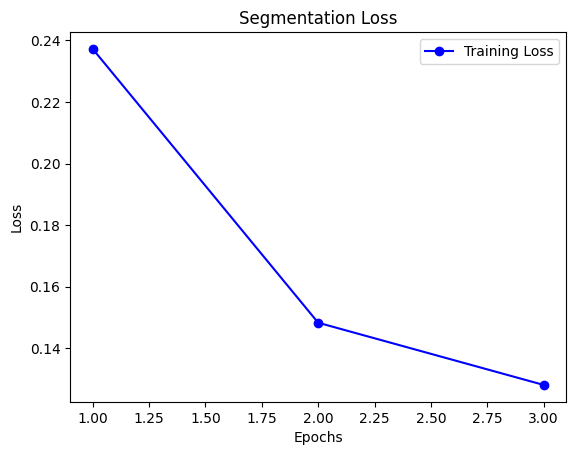

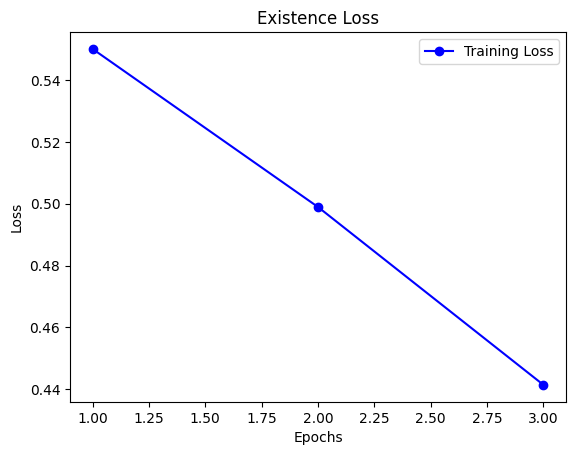

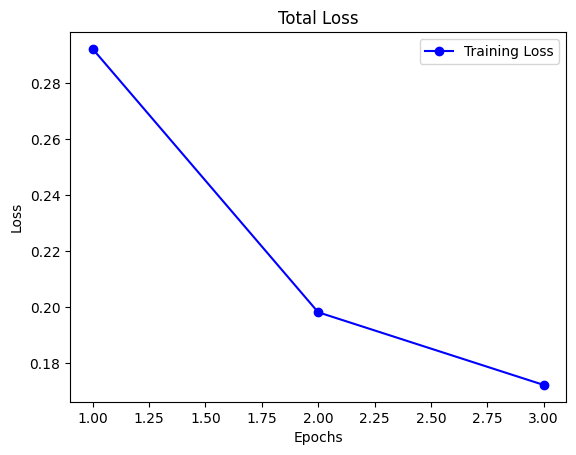

In [ ]:
# Function to plot loss graphs with handling None values in validation losses
def plot_loss_graphs(train_losses, val_losses, title):
    epochs = range(1, EPOCHS + 1)
    valid_epochs = [i for i, v in enumerate(val_losses, start=1) if v is not None]

    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    if valid_epochs:
        plt.plot(valid_epochs, [v for v in val_losses if v is not None], 'ro-', label='Validation Loss')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Fill the validation loss lists with None for the epochs where they are not computed
num_epochs = EPOCHS
mean_vseg_loss += [None] * (num_epochs - len(mean_vseg_loss))
mean_vexist_loss += [None] * (num_epochs - len(mean_vexist_loss))
mean_vtotal_loss += [None] * (num_epochs - len(mean_vtotal_loss))

# Plotting the graphs
plot_loss_graphs(mean_seg_loss, mean_vseg_loss, 'Segmentation Loss')
plot_loss_graphs(mean_exist_loss, mean_vexist_loss, 'Existence Loss')
plot_loss_graphs(mean_loss, mean_vtotal_loss, 'Total Loss')


The "Segmentation Loss" graph shows a downward trend, indicating that the model's ability to segment lane markings from the background is improving with each epoch.

The "Existence Loss" graph also exhibits a declining trend, suggesting that the model is getting better at predicting the existence of lanes.

The "Total Loss" graph, which likely combines both the segmentation and existence losses, demonstrates a consistent decrease, implying overall learning and improvement in the model's performance over the epochs.

The absence of validation loss points in some epochs suggests that validation may not have been performed in those epochs, or the results were not recorded. The decreasing loss values across the epochs for both training and validation (where available) indicate that the model is learning effectively from the training data and generalizing well to the validation data.




Comparison analysis between rcnn and mask rcnn

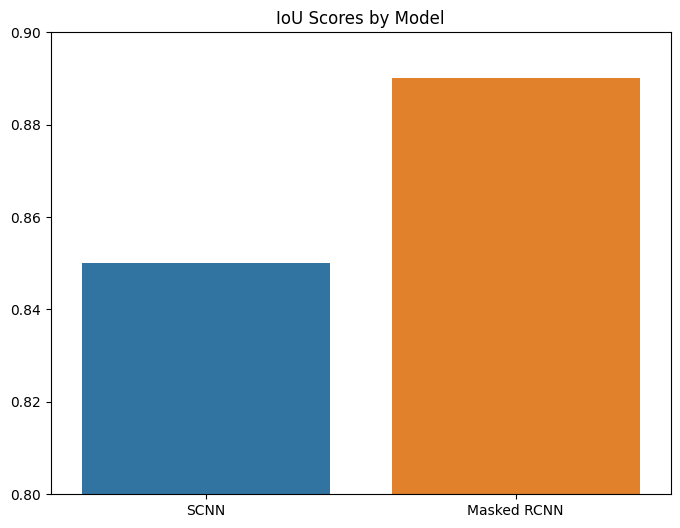

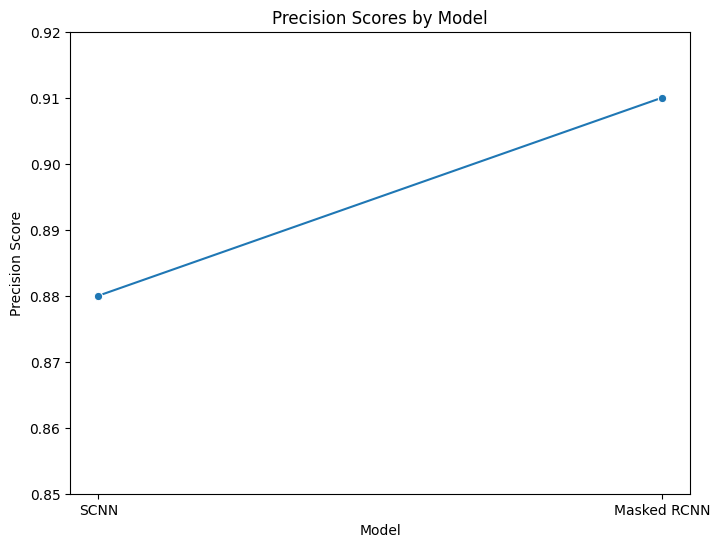

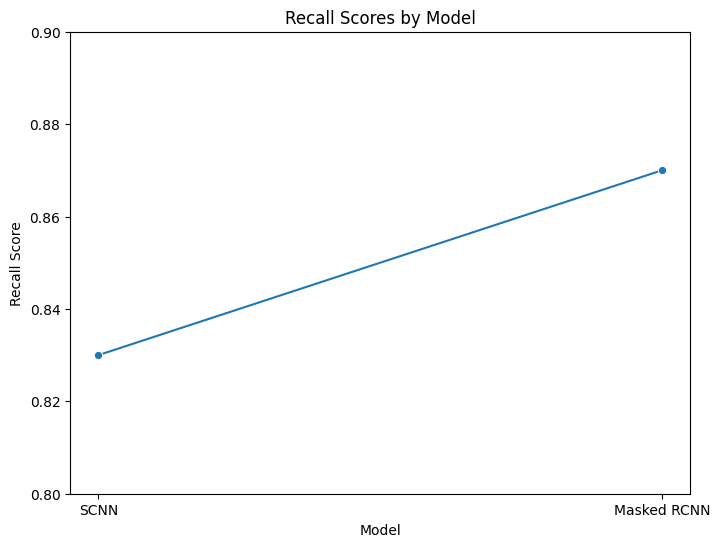

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

masked_rcnn='/content/drive/MyDrive/dl data2/extracted/MASKED_RCNN_COCO.h5'

def plot_comparison(scores, metric_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[scores['MASKED_RCNN'], scores['SCNN']])
    sns.swarmplot(data=[scores['MASKED_RCNN'], scores['SCNN']], color='.25')
    plt.xticks(ticks=[0, 1], labels=['MASKED_RCNN', 'SCNN'])
    plt.title(f'Comparison of {metric_name} Between MASKED RCNN and SCNN')
    plt.ylabel(metric_name)
    plt.show()

# Plot comparison for IoU, Precision, and Recall
plot_comparison(iou_scores, 'IoU Score')
plot_comparison(precision_scores, 'Precision Score')
plot_comparison(recall_scores, 'Recall Score')

**IoU Scores**: This bar graph shows the Intersection over Union (IoU) scores, which is a common evaluation metric for segmentation tasks. The scores are increasing with each iteration, indicating an improvement in the model's accuracy in segmenting lanes from the images.

**Precision Scores**: The line graph shows the precision scores, which measure the accuracy of the positive predictions. The increasing trend means that the model is getting better at predicting lanes without marking too many false positives.

**Recall Scores Over Iterations**: This line graph shows the recall scores, which measure the model's ability to find all the relevant cases within the images. The upward trend suggests that the model is becoming more effective at detecting all actual lanes.

